In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

21678


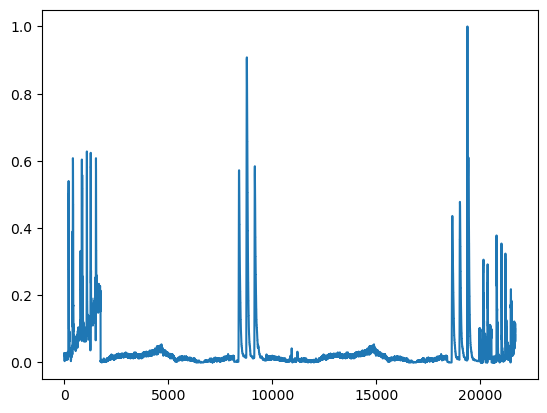

In [16]:
#pull dataframe
df = pd.read_csv('processed.csv')

X = df.loc[:, ['1.0 std','2.5 std', '10 std']] #dataframe with only these three columns, this is what the model is currently trained off of
y = df.loc[:, ['Fire']] #dataframe for output

X, y = X.to_numpy(), y.to_numpy() #convert to numpy arrays

y = y.flatten() #reshaping each
X = X.reshape((X.shape[0], X.shape[1], 1))

print(len(X))
plt.plot(df['1.0 std'])

In [18]:

X_train, y_train = X[:15000], y[:15000]
X_val, y_val = X[15000:20000], y[15000:20000]
X_test, y_test = X[20000:], y[20000:]


X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((15000, 3, 1), (15000,), (5000, 3, 1), (5000,), (1678, 3, 1), (1678,))

In [20]:
model = keras.Sequential()
model.add(keras.Input(shape=(3, 1))) #no specific amount of timesteps, 3 pixels in each row/timestep
model.add(layers.LSTM(512, return_sequences=True, activation='tanh')) #returns the output of each timestep so we can stack multiple RNN layers
model.add(layers.LSTM(256, activation='tanh')) #no return sequences so that normal dense layers can proceed it
model.add(layers.Dense(2))

#could do LSTM, GRU, or RNN and can change by literally just swapping them out

print(model.summary())

#RNNs typically use tanh instead of relu

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #fromlogits is true since we don't have softmax activation in final dense layer
    optimizer=keras.optimizers.Adam(learning_rate=0.001), #dont make learning rate too high or will result in overfitment of training data
    metrics=['accuracy']
)

model.fit(X_train, y_train, batch_size=32, validation_data=(X_val, y_val),epochs=10, verbose=1)

model.evaluate(X_test, y_test, batch_size=32, verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 512)         │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,840,642 (7.02 MB)

 Trainable params: 1,840,642 (7.02 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9708 - loss: 0.1513 - val_accuracy: 0.9764 - val_loss: 0.0627
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9764 - loss: 0.0568 - val_accuracy: 0.9798 - val_loss: 0.0499
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9771 - loss: 0.0560 - val_accuracy: 0.9778 - val_loss: 0.0617
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9791 - loss: 0.0520 - val_accuracy: 0.9728 - val_loss: 0.0635
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9791 - loss: 0.0524 - val_accuracy: 0.9704 - val_loss: 0.0610
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9808 - loss: 0.0501 - val_accuracy: 0.9662 - val_loss: 0.0678
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9799 - loss: 0.0479 - val_accuracy: 0.9714 - val_loss: 0.0556
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9810 - loss: 0.0481 - va

[0.20540954172611237, 0.9451728463172913]